## Define the Convolutional Neural Network


## CNN Architecture

In [9]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=272, bias=True)
  (drop): Dropout(p=0.4)
  (fc2): Linear(in_features=272, out_features=136, bias=True)
)


## Transform the dataset 

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [12]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

In [13]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

In [14]:
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [15]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

In [16]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

In [20]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

In [21]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

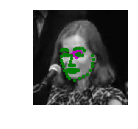

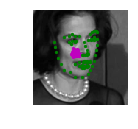

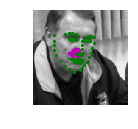

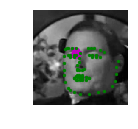

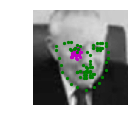

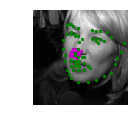

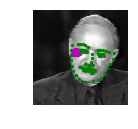

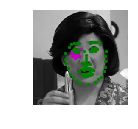

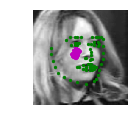

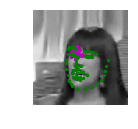

In [22]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

In [23]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


## Training and Initial Observation

In [24]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [25]:
# train your network
n_epochs = 40 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.19795369058847428
Epoch: 1, Batch: 20, Avg. Loss: 0.15107073485851288
Epoch: 1, Batch: 30, Avg. Loss: 0.12742051780223845
Epoch: 1, Batch: 40, Avg. Loss: 0.12322996780276299
Epoch: 1, Batch: 50, Avg. Loss: 0.12048914358019829
Epoch: 1, Batch: 60, Avg. Loss: 0.12519247084856033
Epoch: 1, Batch: 70, Avg. Loss: 0.11443933248519897
Epoch: 1, Batch: 80, Avg. Loss: 0.09660259261727333
Epoch: 1, Batch: 90, Avg. Loss: 0.0954202152788639
Epoch: 1, Batch: 100, Avg. Loss: 0.11247682198882103
Epoch: 1, Batch: 110, Avg. Loss: 0.09402210414409637
Epoch: 1, Batch: 120, Avg. Loss: 0.10307958051562309
Epoch: 1, Batch: 130, Avg. Loss: 0.10042809322476387
Epoch: 1, Batch: 140, Avg. Loss: 0.10990801826119423
Epoch: 1, Batch: 150, Avg. Loss: 0.10482346042990684
Epoch: 1, Batch: 160, Avg. Loss: 0.08969014063477516
Epoch: 1, Batch: 170, Avg. Loss: 0.09837139695882798
Epoch: 2, Batch: 10, Avg. Loss: 0.11279653757810593
Epoch: 2, Batch: 20, Avg. Loss: 0.1121602937579155
Epoch:

## Test data

In [26]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


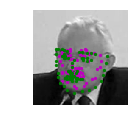

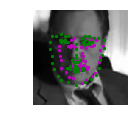

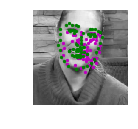

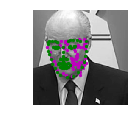

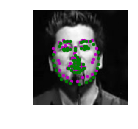

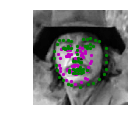

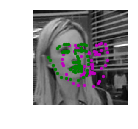

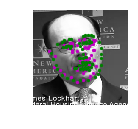

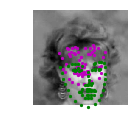

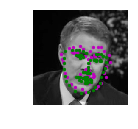

In [27]:
visualize_output(test_images, test_outputs, gt_pts)

In [28]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

In [17]:

## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=272, bias=True)
  (drop): Dropout(p=0.4)
  (fc2): Linear(in_features=272, out_features=136, bias=True)
)

[[ 0.06299692  0.03697932  0.01169727  0.13205618  0.23289137]
 [-0.13805589  0.09122776  0.1011511   0.01393096 -0.02784191]
 [-0.0136913  -0.00853947 -0.14286858 -0.16145834 -0.16528994]
 [-0.12969337 -0.12112158  0.08110703  0.04467875  0.10560679]
 [-0.10491548 -0.01808781  0.11140206  0.04622329  0.02152851]]
(5, 5)


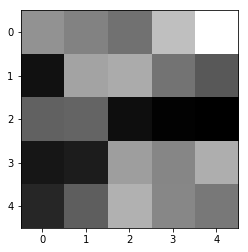

In [21]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
plt.show()

## Feature maps

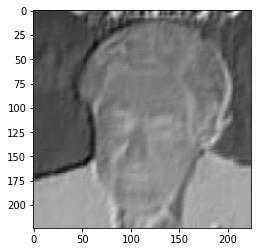

In [22]:
import cv2
img = test_dataset[0]["image"].numpy().reshape(224, 224)
plt.imshow(img, cmap='gray')
dst = cv2.filter2D(img, -1, w[4][0])
plt.imshow(dst, cmap='gray')
plt.show()